___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___
# Recommender Systems with Python

Welcome to the code notebook for Recommender Systems with Python. In this lecture we will develop basic recommendation systems using Python and pandas. There is another notebook: *Advanced Recommender Systems with Python*. That notebook goes into more detail with the same data set.

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

There is no project for this topic, instead you have the option to work through the advanced lecture version of this notebook (totally optional!).

Let's get started!

## Import Libraries

In [43]:
import numpy as np
import pandas as pd

## Get the Data

In [44]:
# @hidden_cell
from io import StringIO
import requests
import json
import pandas as pd

# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_19099026f8df40b6aec4353c7e897e95(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_5c7ca48007cfb646b75667f037d9ca9a469d66ad','domain': {'id': '595d59e0d3fe4089afc692bd55396f11'},
            'password': 'C_8vk=7&^H1Oa~XJ'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df= pd.read_csv(get_object_storage_file_with_credentials_19099026f8df40b6aec4353c7e897e95('PythonMachineLearning', 'u.data.csv'),sep='\t', names=column_names)
df.head()


,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [45]:
#column_names = ['user_id', 'item_id', 'rating', 'timestamp']
#df = pd.read_csv('u.data', sep='\t', names=column_names)

In [46]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Now let's get the movie titles:

In [47]:
movie_titles = pd.read_csv(get_object_storage_file_with_credentials_19099026f8df40b6aec4353c7e897e95('PythonMachineLearning', 'Movie_Id_Titles.csv'))
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [48]:
#movie_titles = pd.read_csv("Movie_Id_Titles")
#movie_titles.head()

We can merge them together:

In [49]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Let's create a ratings dataframe with average rating and number of ratings:

In [51]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [52]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [53]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Now set the number of ratings column:

In [54]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now a few histograms:

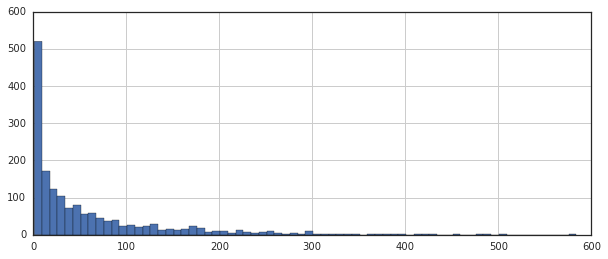

In [55]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

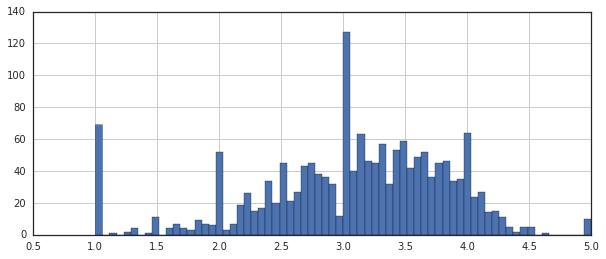

In [56]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

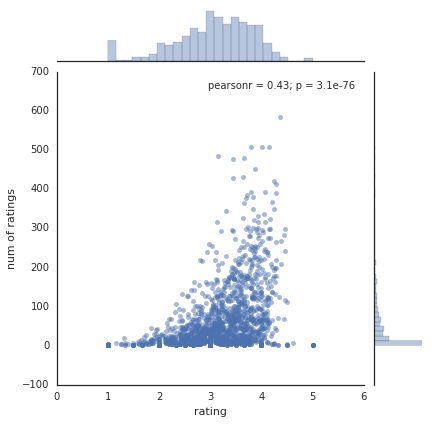

In [57]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

## Recommending Similar Movies

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [71]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most rated movie:

In [72]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

In [73]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now let's grab the user ratings for those two movies:

In [64]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [75]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

similar_to_starwars.head()

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [78]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

In [79]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [81]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now sort the values and notice how the titles make a lot more sense:

In [82]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Now the same for the comedy Liar Liar:

In [83]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


# Great Job!